# Damage Library

This module provides a computational framework for constructing degrading models inspired by the hypothesis of @kachanov1958vremeni. A survey of the resulting theory is given by @krajcinovic1995continuum.


The complete implementation follows the approach described by @ngoc2017damage.
A notable implementation of a similar model is the `*CONCRETE DAMAGED PLASTICITY` model provided by the program ABAQUS, and based on the work of @lee1998plasticdamage.

The core concept is to take an existing *basis* model for a work-conjugate pair of variables, and construct a new model which progressively deteriorates the response of the basis model.

In the univariate case, it is postulated that degredation takes the form

$$
\begin{aligned}
\sigma &= (1 - d) \bar{\sigma} \\
E &= (1 - d) \bar{E}
\end{aligned}
$$


The internal variable, $d$, varies from $0$ to $1$ and evolves according to a *dissipation* rule that is defined by assigning an *accumulation* relation over an energy 
interval, $\{\psi_{d0}, \psi_{d1}\}$.

In [1]:
from damage import (
    # Submodules
    accumulation,
    dissipation ,
    # Wrapper
    FedeasUniaxialDamage
)
from opensees import uniaxial
from opensees.tcl import dumps

### Accumulation Rules

The `accumulation` submodule is a library of accumulation models. An accumulation object
has the following methods:

- ```python
  AccumulationModel.getIndex(psi: float) -> DamageIndex
  ```
  where `DamageIndex` has scalar fields `y` and `dydx` containing the value and
  tangent, respectively, of the accumulation function at the given normalized
  energy, `psy`.

>**NOTE** This design uses a single method to return both the value and tangent
of the accumulation model. It may be preferable to change this for consistency with
the OpenSees style, where models have distinct `getResponse` and `getTangent` methods.

In [2]:
from numpy import linspace
psi = linspace(0.01, 1., 100)

In [3]:
a = accumulation.OBeta(1, [4., 8.])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


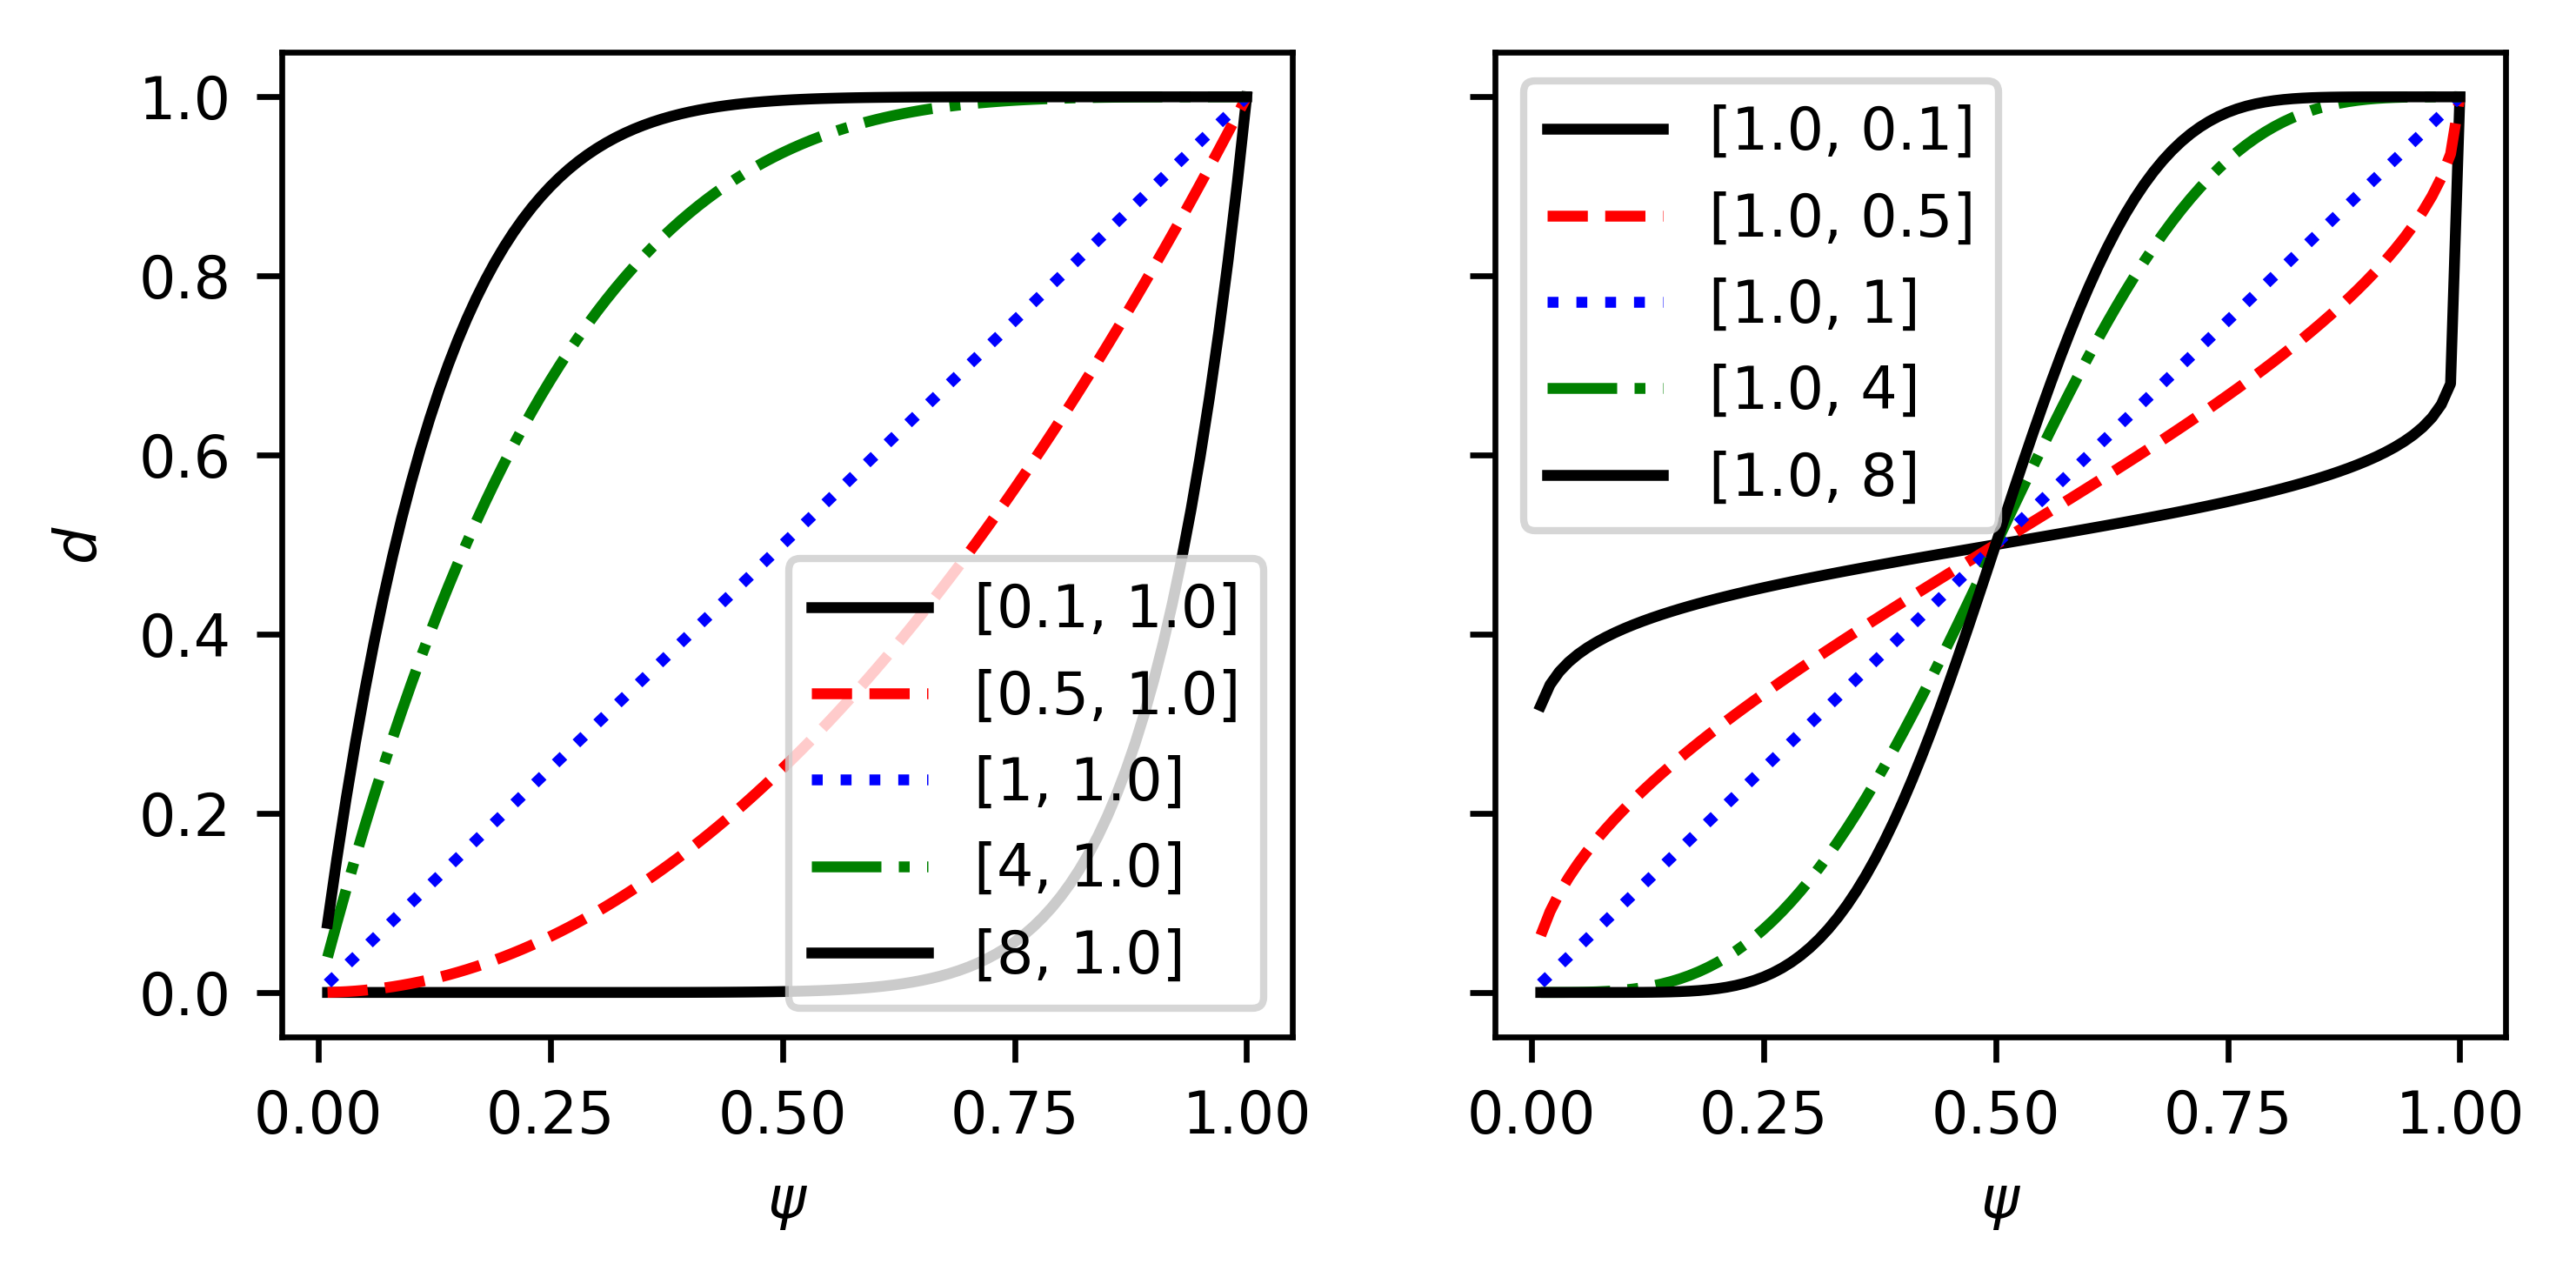

In [4]:
import matplotlib.pyplot as plt
# plt.style.use("science")
plt.style.use("ieee") ###
# plt.style.use("nature")
# plt.style.use("retro")
fig, axs = plt.subplots(1,2, figsize=(5.5,2.5),  sharey=True)

parameter_range = [0.1, 0.5, 1, 4, 8]
parameters = [None, None]

for i,ax in enumerate(axs):
    for param in parameter_range:
        parameters[i] = param
        parameters[not i] = 1.0
        a = accumulation.MBeta(None, parameters)
        ax.plot(psi, [a.getIndex(x).y for x in psi], label=f"{parameters}")
    ax.legend()
    # ax.axis("equal")
    ax.set_xlabel(r"$\psi$")
axs[0].set_ylabel(r"$d$");

### Dissipation

The `DirectionalTotal` dissipation rule specifies the maner in which energy is dissipated for a particular loading direction. This allows distinct strategies to be applied in tension and compression.

A directional dissipation rule can be defined in the following ways:

- `DirectionalTotal(accum, interval, )`




In [5]:
interval  = []  # [Cd0, Cd1]
cycle     =     # Cwc
scale     = [E, fy]

SyntaxError: invalid syntax (2423399355.py, line 2)

In [ ]:
d = dissipation.Directional(a, threshold, cycle, scale)

In [ ]:
# Directional Coupling
coupling  = [0.1, 0.1]    # Ccd

In [ ]:
# or, if threshold is normalized:     
# d = dissipation.Directional(a, threshold, cycle)

base = uniaxial.Steel02(1, ...)

m = FedeasUnivariateDamage(1, base,  d)
m = FedeasUnivariateDamage(1, base, coupling)
m = FedeasUnivariateDamage(1, base, )

In [ ]:
print(dumps(m))

In [ ]:
m.get_refs